In [40]:
import numpy as np
import voxelmorph as vxm
# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

In [41]:
from tensorflow.keras import backend as K
# tf.debugging.set_log_device_placement(True)

In [42]:
tf.compat.v1.disable_eager_execution()

In [43]:
# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()

In [44]:
# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

In [45]:
# let's load up MNIST
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train_all = x_train_all.astype('float')/255
x_test_all = x_test_all.astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

vol_shape = list(x_train_all.shape[1:-1])

In [46]:
# extract all 3s
digit = 3

x_train = x_train_all[y_train_all == digit, ...]
y_train = y_train_all[y_train_all == digit]
x_test = x_test_all[y_test_all == digit, ...].astype('float')/255
y_test = y_test_all[y_test_all == digit]

In [56]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs

# let's make sure the sizes make sense
sample = next(template_gen(x_train, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(8, 32, 32, 1), (8, 32, 32, 1), (8, 32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

In [48]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [49]:
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [50]:
model.summary()

Model: "template_creation_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source_input (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
atlas (LocalParamWithInput)     (None, 32, 32, 1)    1024        source_input[0][0]               
__________________________________________________________________________________________________
vxm_dense_unet_input_concat (Co (None, 32, 32, 2)    0           atlas[0][0]                      
                                                                 source_input[0][0]               
__________________________________________________________________________________________________
vxm_dense_unet_enc_conv_0_0 (Co (None, 32, 32, 16)   304         vxm_dense_unet_

In [58]:
# prepare losses and compile
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [59]:
# train model
gen = template_gen(x_train, batch_size=8)
hist = model.fit(gen, epochs=1, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s2023-08-08 23:33:41.835180: W tensorflow/c/c_api.cc:326] Operation '{name:'vxm_dense_flow_resize_1/map/while' id:15082 op device:{} def:{{{node vxm_dense_flow_resize_1/map/while}} = StatelessWhile[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_INT32, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=249, _read_only_resource_inputs=[], body=vxm_dense_flow_resize_1_map_while_body_39117[], cond=vxm_dense_flow_resize_1_map_while_cond_39116[], output_shapes=[[], [], [], [], [], ..., [], [], [], [], []], parallel_iterations=10](vxm_dense_flow_resize_1/map/while/loop_counter, vxm_dense_flow_resize_1/map/strided_slice, vxm_dense_flow_resize_1/map/Const, vxm_dense_flow_resize_1/map/TensorArrayV2_1, vxm_dense_flow_resize_1/map/strided_slice, vxm_dense_flow_resize_1/map/TensorArrayUnstack/TensorListFromTensor, vxm_dense_flow_resize_1/map/while/EmptyTensorList, vxm_dense_flow_res

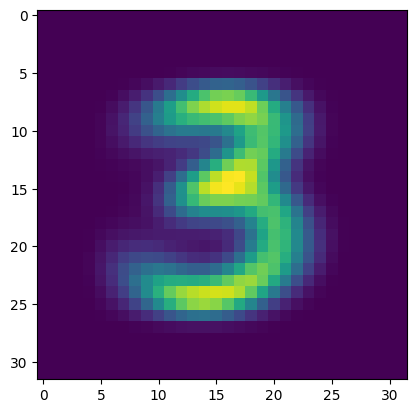

In [92]:
plt.imshow(next(gen)[0][1].squeeze()[3])

In [98]:
out_put.shape

(8, 32, 32, 2)

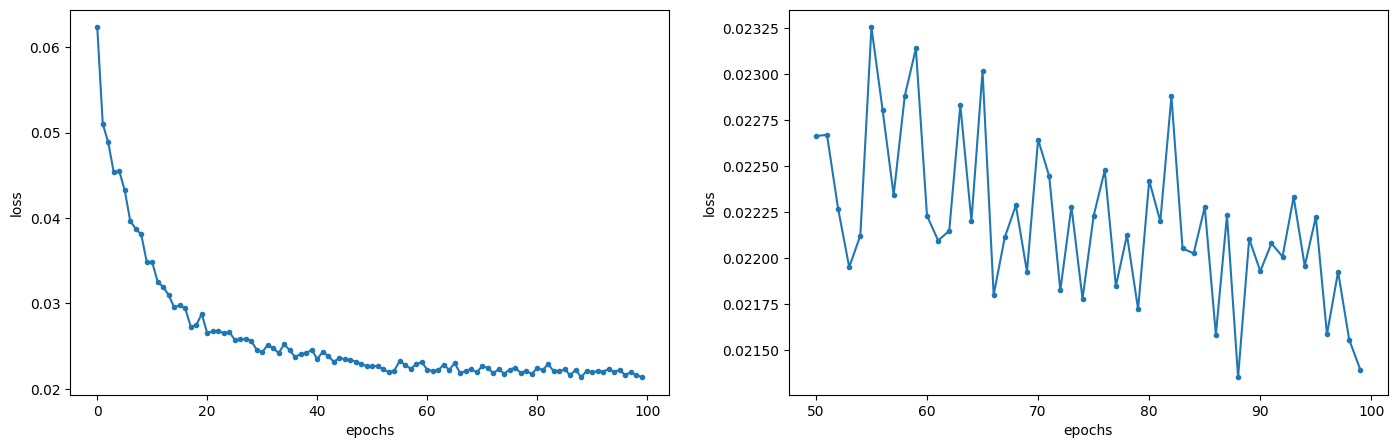

In [16]:
plot_hist(hist)

In [13]:
model.references.atlas_layer.get_weights()

[array([[[-7.2511559e-04],
         [-5.1255061e-05],
         [ 7.6097425e-04],
         ...,
         [ 7.4582058e-04],
         [ 5.3091958e-04],
         [-1.9737576e-04]],
 
        [[ 1.6015887e-04],
         [ 4.6075051e-04],
         [ 8.3624257e-04],
         ...,
         [-5.0262263e-04],
         [-1.4414613e-03],
         [-1.1287576e-03]],
 
        [[-4.0466961e-04],
         [-4.4876736e-04],
         [-4.2101979e-05],
         ...,
         [ 2.5203703e-03],
         [-8.4015401e-04],
         [-2.0496087e-04]],
 
        ...,
 
        [[ 4.4649807e-04],
         [ 1.1572905e-03],
         [-1.5887187e-03],
         ...,
         [-1.1330522e-03],
         [-2.5760997e-03],
         [-6.7124231e-05]],
 
        [[ 8.8889268e-04],
         [-2.7286744e-04],
         [-1.3278828e-03],
         ...,
         [-3.5644558e-03],
         [-1.2723044e-03],
         [-7.0966722e-05]],
 
        [[ 9.5974735e-04],
         [ 3.3941455e-04],
         [-7.8561326e-04],
         

Text(0.5, 1.0, 'atlas')

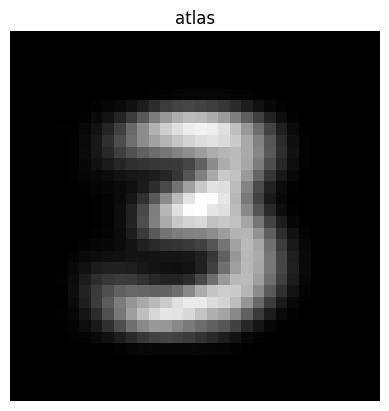

In [17]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(atlas, cmap='gray')
plt.axis('off');
plt.title('atlas')

In [20]:
m = model.references.atlas_layer.get_weights()

In [22]:
m[0].shape

(32, 32, 1)